# Forest Fire Prediction

several Data Mining methods were applied. After fitting the models, the outputs were
post-processed with the inverse of the ln(x+1) transform. Four different input setups were
used. The experiments were conducted using a 10-fold (cross-validation) x 30 runs. Two
regression metrics were measured: MAD and RMSE. A Gaussian support vector machine (SVM) fed
with only 4 direct weather conditions (temp, RH, wind and rain) obtained the best MAD value:
12.71 +- 0.01 (mean and confidence interval within 95% using a t-student distribution). The
best RMSE was attained by the naive mean predictor. An analysis to the regression error curve
(REC) shows that the SVM model predicts more examples within a lower admitted error. In effect,
the SVM model predicts better small fires, which are the majority.

Relevant Information:

This is a very difficult regression task. It can be used to test regression methods. Also,
it could be used to test outlier detection methods, since it is not clear how many outliers
are there. Yet, the number of examples of fires with a large burned area is very small.

Number of Instances: 517

Number of Attributes: 12 + output attribute

Note: several of the attributes may be correlated, thus it makes sense to apply some sort of
feature selection.

Attribute information:

For more information, read [Cortez and Morais, 2007].

X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
month - month of the year: "jan" to "dec"
day - day of the week: "mon" to "sun"
FFMC - FFMC index from the FWI system: 18.7 to 96.20
DMC - DMC index from the FWI system: 1.1 to 291.3
DC - DC index from the FWI system: 7.9 to 860.6
ISI - ISI index from the FWI system: 0.0 to 56.10
temp - temperature in Celsius degrees: 2.2 to 33.30
RH - relative humidity in %: 15.0 to 100
wind - wind speed in km/h: 0.40 to 9.40
rain - outside rain in mm/m2 : 0.0 to 6.4
area - the burned area of the forest (in ha): 0.00 to 1090.84
(this output variable is very skewed towards 0.0, thus it may make
sense to model with the logarithm transform).
Missing Attribute Values: None

In [2]:
pwd

'C:\\Users\\gokul\\Desktop\\Forest fire Prediction'

In [1]:
!pip install findspark

In [4]:
import pandas as pd
import sweetviz as sz
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
datae = pd.read_csv('forestfires.csv')

In [4]:
datae

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


## Lets make the area to gaussian( Exponential) 

In [5]:
datae['area'] = datae.area**(1/5) 

In [6]:
datae.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [7]:
datae.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,0.792384
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,0.839986
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.877406
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,1.457180
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,4.050906


In [8]:
for col in datae.columns:
    print(col, datae[col].unique(), datae[col].dtype)

X [7 8 6 5 4 2 9 1 3] int64
Y [5 4 6 3 2 9 8] int64
month ['mar' 'oct' 'aug' 'sep' 'apr' 'jun' 'jul' 'feb' 'jan' 'dec' 'may' 'nov'] object
day ['fri' 'tue' 'sat' 'sun' 'mon' 'wed' 'thu'] object
FFMC [86.2 90.6 91.7 89.3 92.3 91.5 91.  92.5 92.8 63.5 90.9 92.9 93.3 84.9
 89.2 86.3 91.8 94.3 90.2 93.5 91.4 92.4 93.4 88.6 90.3 90.  88.1 79.5
 94.8 90.1 94.2 87.2 87.6 92.1 92.6 84.  86.6 93.  91.1 91.2 88.8 84.2
 89.7 83.9 69.  82.1 85.9 84.4 68.2 93.7 85.8 95.5 95.2 96.  85.6 81.5
 86.8 93.9 90.8 90.7 88.3 92.2 81.9 88.  83.  93.1 91.9 91.6 87.5 93.6
 84.6 85.4 84.7 86.9 85.2 90.4 53.4 85.1 89.6 50.4 88.2 92.  18.7 90.5
 84.1 85.  87.9 94.6 87.1 92.7 88.9 89.4 94.  75.1 91.3 93.2 94.9 95.
 95.1 95.8 95.9 96.2 96.1 94.5 81.6 94.4] float64
DMC [ 26.2  35.4  43.7  33.3  51.3  85.3  88.9 145.4 129.5  88.   73.2  70.8
 126.5 133.3 141.2  35.8  32.8  27.9  27.4  78.5  96.3 110.9 139.4 142.4
 117.9 149.3  85.1  91.8  69.7  75.6  80.7  41.5  25.7  60.6  96.9 108.3
  82.9  62.3  23.9  52.2 137.   

## Visualization

In [9]:
categori = [var for var in datae.columns if datae[var].dtype == 'O']
print('the no of categoricals', len(categori))

the no of categoricals 2


In [10]:
numerical = [var for var in datae.columns if datae[var].dtype != 'O']
print('the no of numericals', len(numerical))

the no of numericals 11


<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='X'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='Y'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='FFMC'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='DMC'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='DC'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='ISI'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='temp'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='RH'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='wind'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='rain'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='area'>

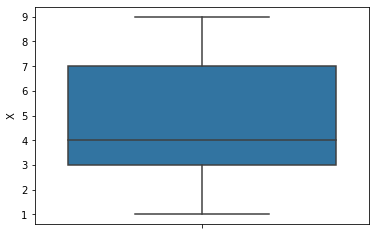

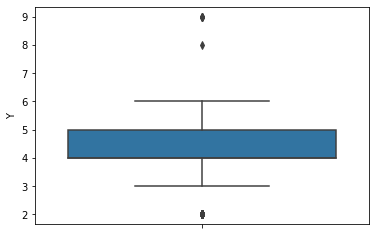

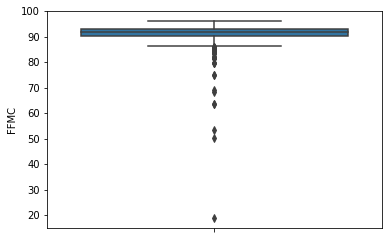

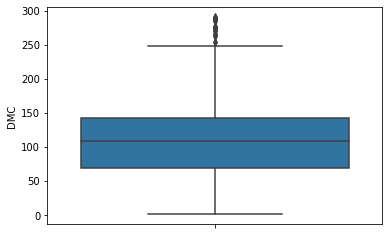

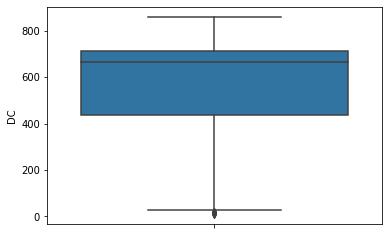

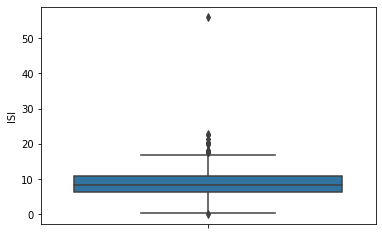

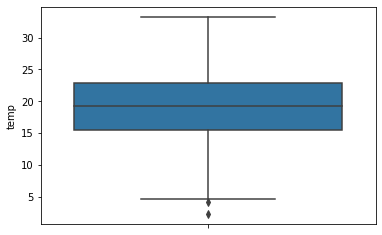

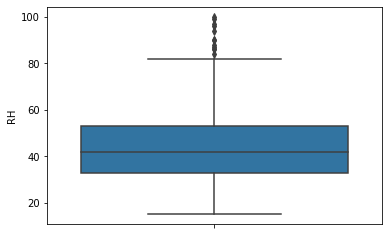

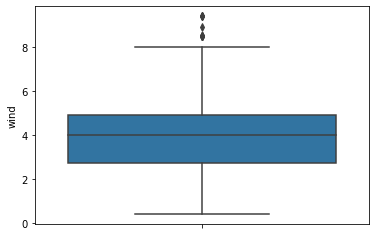

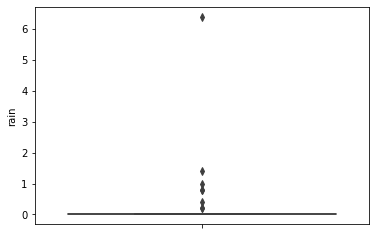

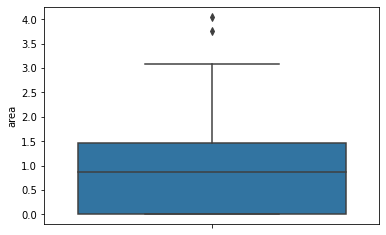

In [11]:
df1 = datae.select_dtypes([np.int64, np.float64])
for i, col in enumerate(df1.columns):
    plt.figure(i)
    sns.boxplot(y = col, data = df1)

Outliers seen in area, rain, Isi, ffmc, y 

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='month', ylabel='count'>

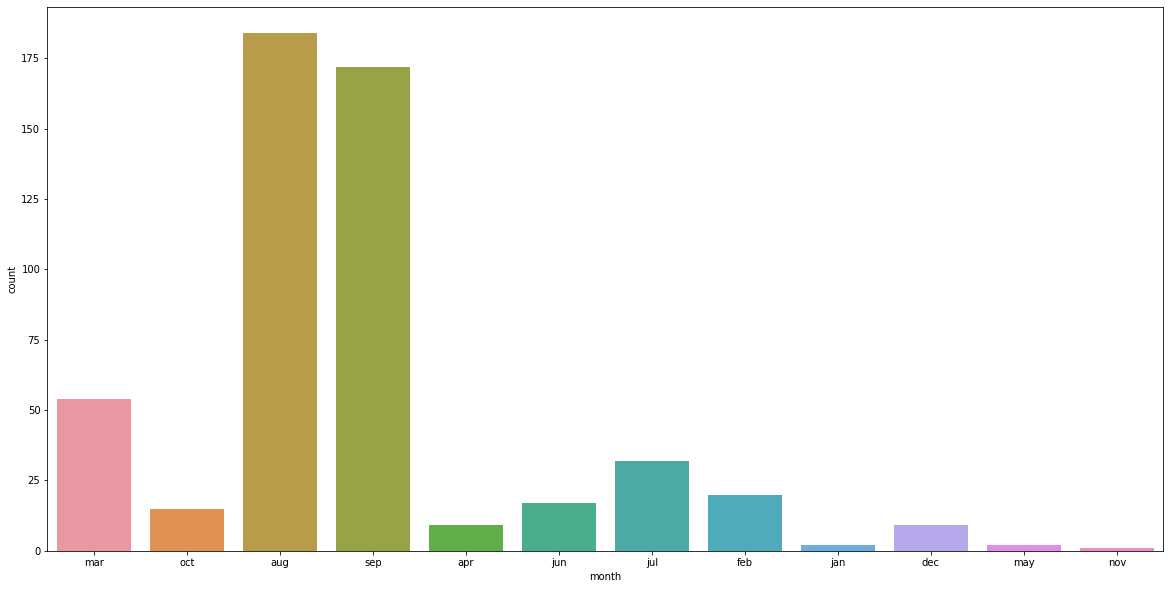

<AxesSubplot:xlabel='day', ylabel='count'>

<Figure size 432x288 with 0 Axes>

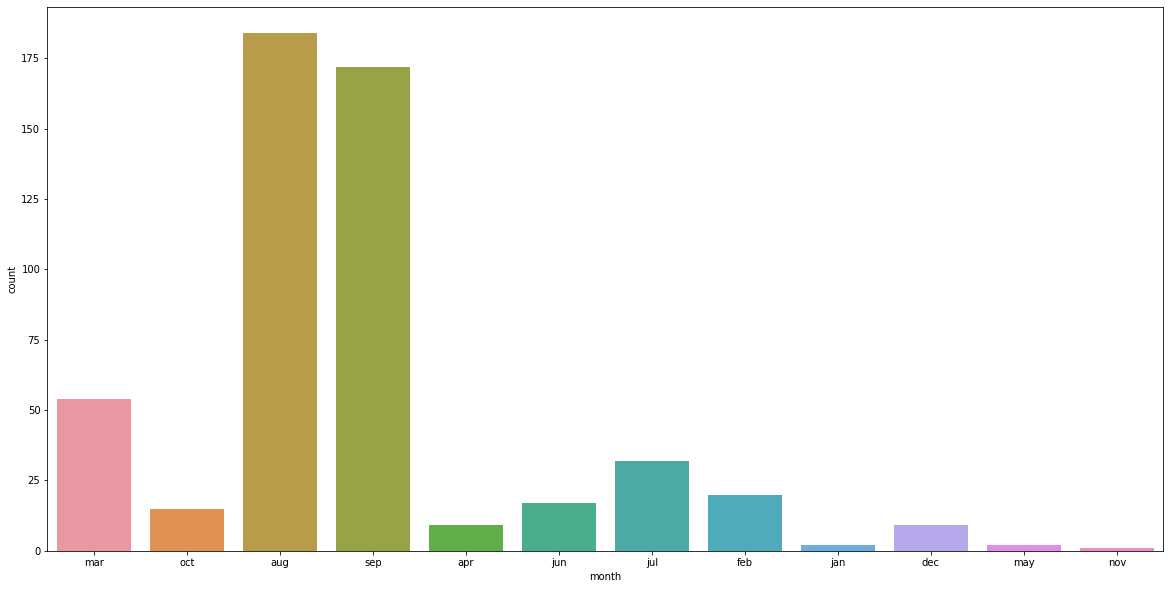

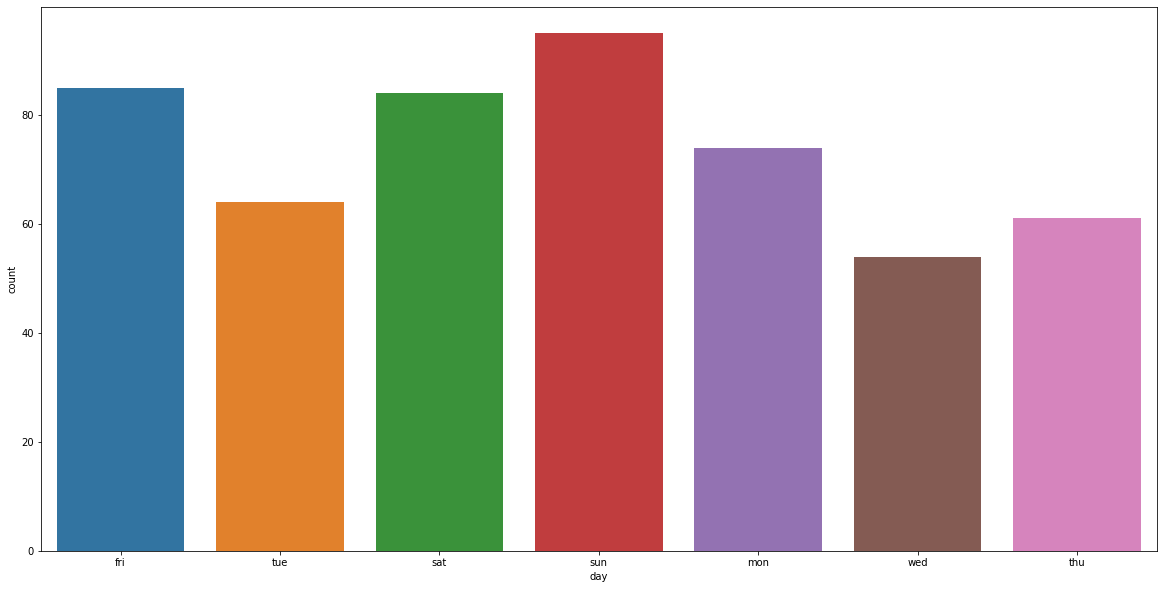

In [12]:
df2 = datae.select_dtypes([np.object])
for i, col in enumerate(df2.columns):
    plt.figure(i)
    fig_dims = (20, 10)
    fig, ax = plt.subplots(figsize=fig_dims)
    sns.countplot(x = col, data = df2, ax = ax)

In [13]:
for col in datae.columns:
    print(col)
    print('-------------------------')
    print(datae[col].value_counts()/np.float(len(datae)))
    print()

X
-------------------------
4    0.176015
6    0.166344
2    0.141199
8    0.117988
7    0.116054
3    0.106383
1    0.092843
5    0.058027
9    0.025145
Name: X, dtype: float64

Y
-------------------------
4    0.392650
5    0.241779
6    0.143133
3    0.123791
2    0.085106
9    0.011605
8    0.001934
Name: Y, dtype: float64

month
-------------------------
aug    0.355899
sep    0.332689
mar    0.104449
jul    0.061896
feb    0.038685
jun    0.032882
oct    0.029014
apr    0.017408
dec    0.017408
may    0.003868
jan    0.003868
nov    0.001934
Name: month, dtype: float64

day
-------------------------
sun    0.183752
fri    0.164410
sat    0.162476
mon    0.143133
tue    0.123791
thu    0.117988
wed    0.104449
Name: day, dtype: float64

FFMC
-------------------------
91.6    0.054159
92.1    0.054159
91.0    0.042553
91.7    0.036750
93.7    0.030948
          ...   
50.4    0.001934
82.1    0.001934
86.3    0.001934
85.1    0.001934
87.1    0.001934
Name: FFMC, Length: 106, dtype

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='X'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='Y'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='month'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='day'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='FFMC'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='DMC'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='DC'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='ISI'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='temp'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='RH'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='wind'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='rain'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='area'>

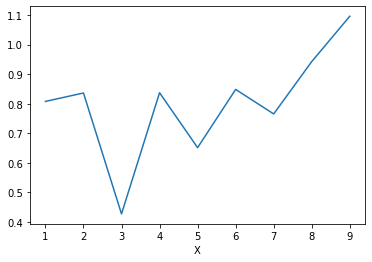

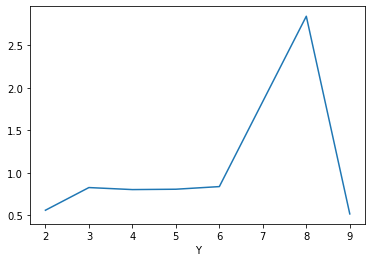

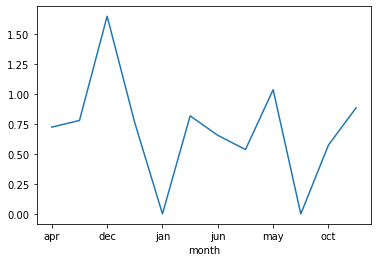

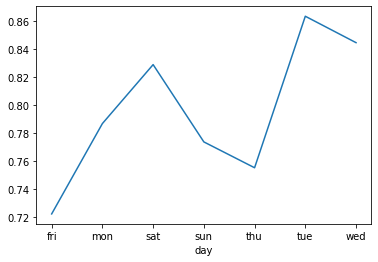

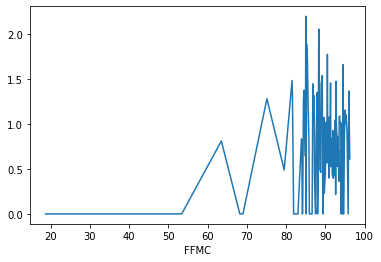

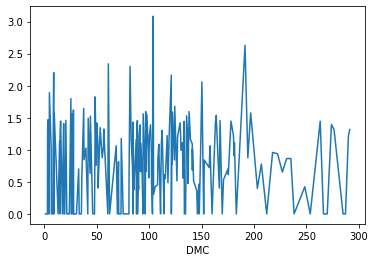

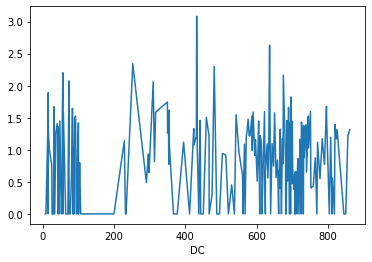

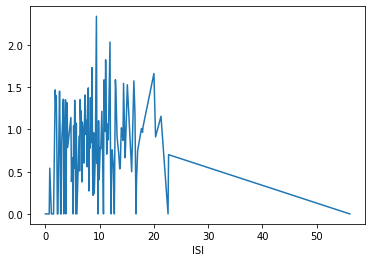

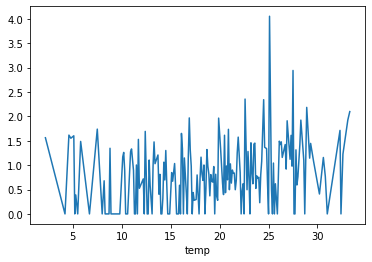

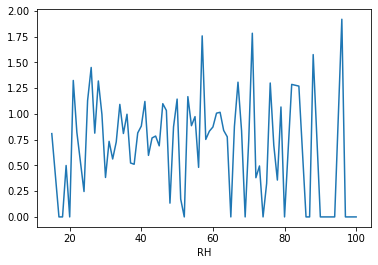

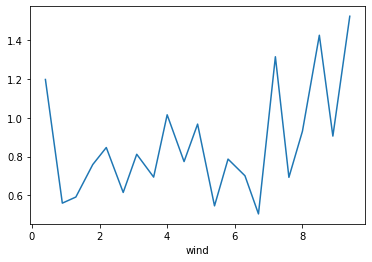

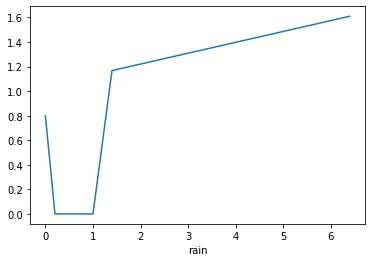

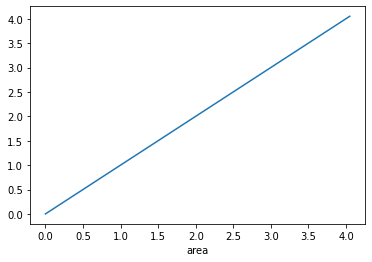

In [14]:
for i, col in enumerate(datae.columns):
    plt.figure(i)
    datae.groupby([col])['area'].mean().plot()

In [15]:
#report = sz.analyze([datae, "Data"], target_feat = 'area')

In [16]:
#report.show_html('forestfire.html')

## Train test split

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(datae, datae.area,test_size=0.25, random_state = 123)

In [19]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((387, 13), (130, 13), (387,), (130,))

## Feature Engineering

### Missing values

There are no missing values in the data

### Outliers and Skewness

For ffmc

In [20]:
IQR = datae.FFMC.quantile(0.75) - datae.FFMC.quantile(0.25)

Lower_fence = xtrain.FFMC.quantile(0.75) - (IQR * 3)

Lower_fence

84.69999999999999

In [21]:
#percentage of outliers
print('lower fence: {}'.format(xtrain[xtrain.FFMC<84.69].shape[0]))
print('percentage of outliers: {}'.format(xtrain[xtrain.FFMC<84.69].shape[0]/np.float(xtrain.shape[0])))

lower fence: 26
percentage of outliers: 0.06718346253229975


In [22]:
# bottom-coding: capping the variable 
xtrain.loc[xtrain.FFMC<=85, 'FFMC'] = 85
xtest.loc[xtest.FFMC<=85, 'FFMC'] = 85
xtrain.FFMC.min(), xtest.FFMC.min()

c:\users\gokul\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
c:\users\gokul\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


(85.0, 85.0)

In [23]:
# and now, I will divide into 10 quantiles for the rest of the exercise. I will leave the quantile
# boundary and generate labels as well for comparison

# create 10 labels, one for each quantile
labels = [i+1 for i in range(0,10)]
print(labels)

# bins with labels
#xtrain['FFMC_label'], bins = pd.qcut(x=xtrain.FFMC, q=10, labels=labels, retbins=True, precision=3, duplicates='raise')

# bins with boundaries
xtrain['FFMC_q'], bins = pd.qcut(x=xtrain.FFMC, q=10, retbins=True, precision=3, duplicates='raise')


xtrain.head(10)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


<ipython-input-23-1fe4d704f198>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain['FFMC_q'], bins = pd.qcut(x=xtrain.FFMC, q=10, retbins=True, precision=3, duplicates='raise')


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,FFMC_q
442,6,5,apr,mon,87.9,24.9,41.6,3.7,10.9,64,3.1,0.0,1.273529,"(85.7, 89.7]"
202,7,4,feb,sun,85.0,8.7,32.1,2.1,8.8,68,2.2,0.0,1.671561,"(84.999, 85.7]"
276,4,4,dec,mon,85.4,25.4,349.7,2.6,4.6,21,8.5,0.0,1.779622,"(84.999, 85.7]"
120,3,4,aug,mon,91.5,145.4,608.2,10.7,10.3,74,2.2,0.0,0.000000,"(91.2, 91.6]"
150,6,5,jun,fri,92.5,56.4,433.3,7.1,23.2,39,5.4,0.0,1.035403,"(92.1, 92.5]"
178,2,5,sep,wed,90.1,82.9,735.7,6.2,18.3,45,2.2,0.0,1.373042,"(89.7, 90.7]"
142,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.905870,"(89.7, 90.7]"
363,4,3,sep,tue,91.9,111.7,770.3,6.5,15.9,53,2.2,0.0,1.239862,"(91.6, 92.1]"
439,1,3,sep,fri,91.1,91.3,738.1,7.2,19.1,46,2.2,0.0,0.801130,"(90.7, 91.2]"
469,6,3,apr,sun,91.0,14.6,25.6,12.3,13.7,33,9.4,0.0,2.276412,"(90.7, 91.2]"


In [24]:
bins

array([85. , 85.7, 89.7, 90.7, 91.2, 91.6, 92.1, 92.5, 93.1, 94.3, 96.2])

In [25]:
# we use pandas cut method and pass the quantile edges calculated in the training set
#xtest['FFMC_label'] = pd.cut(x =xtest.FFMC, bins=bins, labels=labels)
xtest['FFMC_q'] = pd.cut(x = xtest.FFMC, bins=bins)
xtest.head()

<ipython-input-25-e7181ef63ee7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtest['FFMC_q'] = pd.cut(x = xtest.FFMC, bins=bins)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,FFMC_q
400,9,5,jun,wed,93.3,49.5,297.7,14.0,28.0,34,4.5,0.0,1.521732,"(93.1, 94.3]"
379,4,5,jan,sun,85.0,1.1,171.4,0.0,5.2,100,0.9,0.0,0.000000,NaN
286,7,6,jul,wed,91.2,183.1,437.7,12.5,12.6,90,7.6,0.2,0.000000,"(90.7, 91.2]"
125,3,4,oct,sun,92.6,46.5,691.8,8.8,20.6,24,5.4,0.0,0.000000,"(92.5, 93.1]"
216,4,4,sep,sun,92.4,124.1,680.7,8.5,16.9,60,1.3,0.0,1.967458,"(92.1, 92.5]"


In [26]:
xtest.groupby('FFMC_q')['FFMC'].count()/np.float(len(xtest))

FFMC_q
(85.0, 85.7]    0.007692
(85.7, 89.7]    0.123077
(89.7, 90.7]    0.107692
(90.7, 91.2]    0.100000
(91.2, 91.6]    0.092308
(91.6, 92.1]    0.084615
(92.1, 92.5]    0.100000
(92.5, 93.1]    0.053846
(93.1, 94.3]    0.138462
(94.3, 96.2]    0.115385
Name: FFMC, dtype: float64

In [27]:
# order the intervals 
ordered_labels = xtrain.groupby(['FFMC_q'])['area'].mean().sort_values().index

# number the intervals according to survival rate
ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 

# remap the intervals to the encoded variable
xtrain['FFMC_label_ordered'] = xtrain.FFMC_q.map(ordinal_label)
xtest['FFMC_label_ordered'] = xtest.FFMC_q.map(ordinal_label)

xtrain.head()

<ipython-input-27-060fa42fca42>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain['FFMC_label_ordered'] = xtrain.FFMC_q.map(ordinal_label)
<ipython-input-27-060fa42fca42>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtest['FFMC_label_ordered'] = xtest.FFMC_q.map(ordinal_label)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,FFMC_q,FFMC_label_ordered
442,6,5,apr,mon,87.9,24.9,41.6,3.7,10.9,64,3.1,0.0,1.273529,"(85.7, 89.7]",0
202,7,4,feb,sun,85.0,8.7,32.1,2.1,8.8,68,2.2,0.0,1.671561,"(84.999, 85.7]",8
276,4,4,dec,mon,85.4,25.4,349.7,2.6,4.6,21,8.5,0.0,1.779622,"(84.999, 85.7]",8
120,3,4,aug,mon,91.5,145.4,608.2,10.7,10.3,74,2.2,0.0,0.000000,"(91.2, 91.6]",1
150,6,5,jun,fri,92.5,56.4,433.3,7.1,23.2,39,5.4,0.0,1.035403,"(92.1, 92.5]",6


For rain

In [28]:
IQR = datae.rain.quantile(0.75) - datae.rain.quantile(0.25)

Upper_fence = xtrain.rain.quantile(0.75) + (IQR * 3)

Upper_fence

0.0

In [29]:
#percentage of outliers
print('percentage of outliers: {}'.format(xtrain[xtrain.rain<0].shape[0]/np.float(xtrain.shape[0])))

percentage of outliers: 0.0


In [30]:
for col in xtest.columns:
    print(col)
    print('-------------------------')
    print(xtest[col].value_counts()/np.float(len(xtest)))
    print()

X
-------------------------
4    0.215385
2    0.153846
8    0.130769
6    0.130769
7    0.115385
1    0.076923
3    0.069231
9    0.053846
5    0.053846
Name: X, dtype: float64

Y
-------------------------
4    0.384615
5    0.207692
6    0.176923
3    0.138462
2    0.061538
9    0.030769
Name: Y, dtype: float64

month
-------------------------
aug    0.361538
sep    0.315385
jul    0.100000
mar    0.092308
feb    0.030769
jun    0.030769
dec    0.023077
oct    0.023077
may    0.007692
apr    0.007692
jan    0.007692
Name: month, dtype: float64

day
-------------------------
sun    0.215385
sat    0.153846
fri    0.153846
mon    0.146154
tue    0.130769
thu    0.123077
wed    0.076923
Name: day, dtype: float64

FFMC
-------------------------
85.0    0.076923
91.6    0.076923
91.0    0.046154
92.4    0.046154
94.8    0.046154
91.7    0.030769
93.7    0.030769
92.1    0.030769
90.2    0.030769
91.2    0.023077
93.5    0.023077
90.6    0.023077
95.1    0.023077
91.1    0.023077
92.9    0

As we see 99 percent of rain is 0. So coloumn rain is negligible

For ISI

In [31]:
IQR = datae.ISI.quantile(0.75) - datae.ISI.quantile(0.25)

Lower_fence = xtrain.ISI.quantile(0.75) - (IQR * 1.5)

Lower_fence

Upper_fence = xtrain.ISI.quantile(0.75) + (IQR * 3)

Upper_fence

4.1999999999999975

23.55

In [32]:
#lOWER CODING
xtrain.loc[xtrain.ISI<=4, 'ISI'] = 4
xtest.loc[xtest.ISI<=4, 'ISI'] = 4
xtrain.ISI.min(), xtest.ISI.min()


c:\users\gokul\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
c:\users\gokul\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


(4.0, 4.0)

In [33]:
#UPPER CODING
xtrain.loc[xtrain.ISI>=24, 'ISI'] = 24
xtest.loc[xtest.ISI>=24, 'ISI'] = 24
xtrain.ISI.max(), xtest.ISI.max()

c:\users\gokul\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
c:\users\gokul\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


(24.0, 22.7)

In [34]:
# and now, I will divide into 10 quantiles for the rest of the exercise. I will leave the quantile
# boundary and generate labels as well for comparison

# create 10 labels, one for each quantile
labels = [i+1 for i in range(0,5)]
print(labels)

# bins with labels
#xtrain['ISI_label'], bins = pd.qcut(x=xtrain.ISI, q=5, labels=labels, retbins=True, precision=3, duplicates='raise')

# bins with boundaries
xtrain['ISI_q'], bins = pd.qcut(x=xtrain.ISI, q=5, retbins=True, precision=3, duplicates='raise')


xtrain.head()

[1, 2, 3, 4, 5]


<ipython-input-34-226e61fdeebf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain['ISI_q'], bins = pd.qcut(x=xtrain.ISI, q=5, retbins=True, precision=3, duplicates='raise')


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,FFMC_q,FFMC_label_ordered,ISI_q
442,6,5,apr,mon,87.9,24.9,41.6,4.0,10.9,64,3.1,0.0,1.273529,"(85.7, 89.7]",0,"(3.999, 6.2]"
202,7,4,feb,sun,85.0,8.7,32.1,4.0,8.8,68,2.2,0.0,1.671561,"(84.999, 85.7]",8,"(3.999, 6.2]"
276,4,4,dec,mon,85.4,25.4,349.7,4.0,4.6,21,8.5,0.0,1.779622,"(84.999, 85.7]",8,"(3.999, 6.2]"
120,3,4,aug,mon,91.5,145.4,608.2,10.7,10.3,74,2.2,0.0,0.000000,"(91.2, 91.6]",1,"(9.2, 12.0]"
150,6,5,jun,fri,92.5,56.4,433.3,7.1,23.2,39,5.4,0.0,1.035403,"(92.1, 92.5]",6,"(6.2, 7.5]"


In [35]:
bins

array([ 4. ,  6.2,  7.5,  9.2, 12. , 24. ])

In [36]:
# we use pandas cut method and pass the quantile edges calculated in the training set
#xtest['ISI_label'] = pd.cut(x =xtest.ISI, bins=bins, labels=labels)
xtest['ISI_q'] = pd.cut(x = xtest.ISI, bins=bins)

xtest.head()

<ipython-input-36-09acc125ec7c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtest['ISI_q'] = pd.cut(x = xtest.ISI, bins=bins)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,FFMC_q,FFMC_label_ordered,ISI_q
400,9,5,jun,wed,93.3,49.5,297.7,14.0,28.0,34,4.5,0.0,1.521732,"(93.1, 94.3]",3.0,"(12.0, 24.0]"
379,4,5,jan,sun,85.0,1.1,171.4,4.0,5.2,100,0.9,0.0,0.000000,NaN,NaN,NaN
286,7,6,jul,wed,91.2,183.1,437.7,12.5,12.6,90,7.6,0.2,0.000000,"(90.7, 91.2]",5.0,"(12.0, 24.0]"
125,3,4,oct,sun,92.6,46.5,691.8,8.8,20.6,24,5.4,0.0,0.000000,"(92.5, 93.1]",7.0,"(7.5, 9.2]"
216,4,4,sep,sun,92.4,124.1,680.7,8.5,16.9,60,1.3,0.0,1.967458,"(92.1, 92.5]",6.0,"(7.5, 9.2]"


In [37]:
# order the intervals 
ordered_labels = xtrain.groupby(['ISI_q'])['area'].mean().sort_values().index

# number the intervals according to survival rate
ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 

# remap the intervals to the encoded variable
xtrain['ISI_label_ordered'] = xtrain.ISI_q.map(ordinal_label)
xtest['ISI_label_ordered'] = xtest.ISI_q.map(ordinal_label)

xtrain.head()

<ipython-input-37-60f4be529568>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain['ISI_label_ordered'] = xtrain.ISI_q.map(ordinal_label)
<ipython-input-37-60f4be529568>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtest['ISI_label_ordered'] = xtest.ISI_q.map(ordinal_label)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,FFMC_q,FFMC_label_ordered,ISI_q,ISI_label_ordered
442,6,5,apr,mon,87.9,24.9,41.6,4.0,10.9,64,3.1,0.0,1.273529,"(85.7, 89.7]",0,"(3.999, 6.2]",0
202,7,4,feb,sun,85.0,8.7,32.1,4.0,8.8,68,2.2,0.0,1.671561,"(84.999, 85.7]",8,"(3.999, 6.2]",0
276,4,4,dec,mon,85.4,25.4,349.7,4.0,4.6,21,8.5,0.0,1.779622,"(84.999, 85.7]",8,"(3.999, 6.2]",0
120,3,4,aug,mon,91.5,145.4,608.2,10.7,10.3,74,2.2,0.0,0.000000,"(91.2, 91.6]",1,"(9.2, 12.0]",1
150,6,5,jun,fri,92.5,56.4,433.3,7.1,23.2,39,5.4,0.0,1.035403,"(92.1, 92.5]",6,"(6.2, 7.5]",2


In [38]:
xtrain['ISI_label_ordered'].unique()

[0, 1, 2, 4, 3]
Categories (5, int64): [0 < 2 < 3 < 1 < 4]

Deleting unwanted columns

In [39]:
del xtrain['FFMC']
del xtrain['ISI']
del xtrain['day']
del xtrain['X']
del xtrain['Y']
del xtrain['rain']

In [40]:
del xtest['FFMC']
del xtest['ISI']
del xtest['day']
del xtest['X']
del xtest['Y']
del xtest['rain']

In [41]:
xtrain

,month,DMC,DC,temp,RH,wind,area,FFMC_q,FFMC_label_ordered,ISI_q,ISI_label_ordered
442,apr,24.9,41.6,10.9,64,3.1,1.273529,"(85.7, 89.7]",0,"(3.999, 6.2]",0
202,feb,8.7,32.1,8.8,68,2.2,1.671561,"(84.999, 85.7]",8,"(3.999, 6.2]",0
276,dec,25.4,349.7,4.6,21,8.5,1.779622,"(84.999, 85.7]",8,"(3.999, 6.2]",0
120,aug,145.4,608.2,10.3,74,2.2,0.000000,"(91.2, 91.6]",1,"(9.2, 12.0]",1
150,jun,56.4,433.3,23.2,39,5.4,1.035403,"(92.1, 92.5]",6,"(6.2, 7.5]",2
...,...,...,...,...,...,...,...,...,...,...,...
98,aug,142.4,601.4,11.6,87,4.5,0.000000,"(91.2, 91.6]",1,"(9.2, 12.0]",1
322,sep,119.0,783.5,16.8,28,4.0,1.001992,"(92.5, 93.1]",7,"(6.2, 7.5]",2
382,aug,217.7,690.0,28.2,29,1.8,1.424228,"(94.3, 96.2]",9,"(12.0, 24.0]",4
365,sep,111.7,770.3,19.6,45,3.1,1.821110,"(91.6, 92.1]",2,"(6.2, 7.5]",2


In [42]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
# transform data
xtrain['month'] = encoder.fit_transform(xtrain['month'])
xtest['month'] = encoder.fit_transform(xtest['month'])

<ipython-input-42-423858589339>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain['month'] = encoder.fit_transform(xtrain['month'])
<ipython-input-42-423858589339>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtest['month'] = encoder.fit_transform(xtest['month'])


In [43]:
xtrain

,month,DMC,DC,temp,RH,wind,area,FFMC_q,FFMC_label_ordered,ISI_q,ISI_label_ordered
442,0,24.9,41.6,10.9,64,3.1,1.273529,"(85.7, 89.7]",0,"(3.999, 6.2]",0
202,3,8.7,32.1,8.8,68,2.2,1.671561,"(84.999, 85.7]",8,"(3.999, 6.2]",0
276,2,25.4,349.7,4.6,21,8.5,1.779622,"(84.999, 85.7]",8,"(3.999, 6.2]",0
120,1,145.4,608.2,10.3,74,2.2,0.000000,"(91.2, 91.6]",1,"(9.2, 12.0]",1
150,6,56.4,433.3,23.2,39,5.4,1.035403,"(92.1, 92.5]",6,"(6.2, 7.5]",2
...,...,...,...,...,...,...,...,...,...,...,...
98,1,142.4,601.4,11.6,87,4.5,0.000000,"(91.2, 91.6]",1,"(9.2, 12.0]",1
322,11,119.0,783.5,16.8,28,4.0,1.001992,"(92.5, 93.1]",7,"(6.2, 7.5]",2
382,1,217.7,690.0,28.2,29,1.8,1.424228,"(94.3, 96.2]",9,"(12.0, 24.0]",4
365,11,111.7,770.3,19.6,45,3.1,1.821110,"(91.6, 92.1]",2,"(6.2, 7.5]",2


## Scaling

In [44]:
training_vars = [var for var in xtrain.columns if var not in ['FFMC_q', 'ISI_q','area']]
training_vars

['month',
 'DMC',
 'DC',
 'temp',
 'RH',
 'wind',
 'FFMC_label_ordered',
 'ISI_label_ordered']

In [45]:
xtrain[training_vars]

,month,DMC,DC,temp,RH,wind,FFMC_label_ordered,ISI_label_ordered
442,0,24.9,41.6,10.9,64,3.1,0,0
202,3,8.7,32.1,8.8,68,2.2,8,0
276,2,25.4,349.7,4.6,21,8.5,8,0
120,1,145.4,608.2,10.3,74,2.2,1,1
150,6,56.4,433.3,23.2,39,5.4,6,2
...,...,...,...,...,...,...,...,...
98,1,142.4,601.4,11.6,87,4.5,1,1
322,11,119.0,783.5,16.8,28,4.0,7,2
382,1,217.7,690.0,28.2,29,1.8,9,4
365,11,111.7,770.3,19.6,45,3.1,2,2


In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [47]:
scaler.fit_transform(xtrain[training_vars])

array([[-1.31981853, -1.32318052, -1.9881968 , ..., -0.54745387,
        -1.49766507, -1.41348726],
       [-0.6375793 , -1.57704557, -2.02570265, ..., -1.04621972,
         1.31932828, -1.41348726],
       [-0.86499238, -1.31534518, -0.7718228 , ...,  2.4451412 ,
         1.31932828, -1.41348726],
       ...,
       [-1.09240545,  1.69812689,  0.57167631, ..., -1.26789342,
         1.67145245,  1.38814946],
       [ 1.18172532,  0.03703464,  0.88869946, ..., -0.54745387,
        -0.79341673, -0.0126689 ],
       [-1.09240545,  0.90205626,  0.81882013, ...,  0.72716996,
         0.26295577, -0.0126689 ]])

In [48]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 442 to 510
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   month               387 non-null    int32   
 1   DMC                 387 non-null    float64 
 2   DC                  387 non-null    float64 
 3   temp                387 non-null    float64 
 4   RH                  387 non-null    int64   
 5   wind                387 non-null    float64 
 6   area                387 non-null    float64 
 7   FFMC_q              387 non-null    category
 8   FFMC_label_ordered  387 non-null    category
 9   ISI_q               387 non-null    category
 10  ISI_label_ordered   387 non-null    category
dtypes: category(4), float64(5), int32(1), int64(1)
memory usage: 25.5 KB


In [49]:
xtrain['FFMC_q'] =xtrain['FFMC_q'].astype('category').cat.codes

<ipython-input-49-14b9444b42e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain['FFMC_q'] =xtrain['FFMC_q'].astype('category').cat.codes


In [50]:
xtrain['FFMC_label_ordered'] =xtrain['FFMC_label_ordered'].astype('category').cat.codes
xtrain['ISI_q'] =xtrain['ISI_q'].astype('category').cat.codes

<ipython-input-50-2e23e0be8b1f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain['FFMC_label_ordered'] =xtrain['FFMC_label_ordered'].astype('category').cat.codes
<ipython-input-50-2e23e0be8b1f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain['ISI_q'] =xtrain['ISI_q'].astype('category').cat.codes


In [51]:
xtrain['ISI_label_ordered'] =xtrain['ISI_label_ordered'].astype('category').cat.codes

<ipython-input-51-711ecd4385c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain['ISI_label_ordered'] =xtrain['ISI_label_ordered'].astype('category').cat.codes


In [52]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 387 entries, 442 to 510
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   month               387 non-null    int32  
 1   DMC                 387 non-null    float64
 2   DC                  387 non-null    float64
 3   temp                387 non-null    float64
 4   RH                  387 non-null    int64  
 5   wind                387 non-null    float64
 6   area                387 non-null    float64
 7   FFMC_q              387 non-null    int8   
 8   FFMC_label_ordered  387 non-null    int8   
 9   ISI_q               387 non-null    int8   
 10  ISI_label_ordered   387 non-null    int8   
dtypes: float64(5), int32(1), int64(1), int8(4)
memory usage: 24.2 KB


In [53]:
xtest[xtest.columns] = xtest[xtest.columns].apply(pd.to_numeric, errors='coerce')

xtest = xtest.fillna(xtest.median())

c:\users\gokul\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
c:\users\gokul\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


## Modeling

In [54]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
xgb_model = xgb.XGBRegressor()

eval_set = [(xtest[training_vars], ytest)]
xgb_model.fit(xtrain[training_vars], ytrain, eval_set=eval_set, verbose=False)

pred = xgb_model.predict(xtrain[training_vars])
print('xgb train mse: {}'.format(mean_squared_error(ytrain, pred)))
pred = xgb_model.predict(xtest[training_vars])
print('xgb test mse: {}'.format(mean_squared_error(ytest, pred)))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

xgb train mse: 0.029163077579129566
xgb test mse: 0.8305047326074118


In [55]:
for col in xtest.columns:
    print(col, xtest[col].unique(), xtest[col].dtype)

month [ 6  4  5  9 10  2  1  3  7  0  8] int32
DMC [ 49.5   1.1 183.1  46.5 124.1  27.2  35.4  85.3 263.1  96.7 111.7 104.2
   6.8  97.9  94.3  32.8  78.5 112.4 217.7  18.5 133.3 129.5 167.6 108.4
  73.2 235.1  48.3 290.  181.3  26.4 178.  122.3  99.   96.2  13.2  25.7
 142.4 121.1 207.  248.4  23.9  75.6 135.7  68.6  88.  108.3  99.6 191.4
 166.9 180.4 141.2 102.3 139.4   9.1 276.3 126.5 147.8 141.3  50.1  33.3
 147.3 145.4 137.  175.5  25.4 105.8  15.6  70.8 132.3 131.7 117.9  26.7
  56.7  52.2 231.1 170.9  90.4  89.5 160.   39.7 130.1 141.1 114.4 169.7
  96.9 266.2  92.1 101.3 119.   80.9  90.  114.3   7.3 227.  135.5 158.
  91.3  51.3  26.2] float64
DC [297.7 171.4 437.7 691.8 680.7 353.5 669.1 488.  795.9 750.5 770.3 474.9
  26.6 542.  744.4 664.2 724.3 573.  690.   41.1 699.6 692.6 684.4 764.
 713.  723.1 313.4 855.3 613.  352.  605.3 589.9 745.3 739.4  43.   67.6
 601.4 674.4 672.6 753.8  64.7 718.3 586.7 355.2 698.6 647.1 631.2 635.9
 752.6 430.8 713.9 751.5 594.2  55.2 395.  8

In [56]:
# Linear Regression Model
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(xtrain[training_vars], ytrain)

# Predictions
predictions = model.predict(xtest[training_vars])

# Scores
print ("Mean Squared Error : ", mean_squared_error(ytest, predictions))
print ("r2 Score : ", r2_score(ytest, predictions))

LinearRegression()

Mean Squared Error :  0.6587332520534003
r2 Score :  -0.015506285036039236


In [57]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
rf_model = RandomForestRegressor()
rf_model.fit(xtrain[training_vars], ytrain)

pred = rf_model.predict(xtrain[training_vars])
print('rf train mse: {}'.format(mean_squared_error(ytrain, pred)))
pred = rf_model.predict(xtest[training_vars])
print('rf test mse: {}'.format(mean_squared_error(ytest, pred)))

RandomForestRegressor()

rf train mse: 0.1277528444121123
rf test mse: 0.7036507569456255


In [58]:
SVR_model = SVR()
SVR_model.fit(scaler.transform(xtrain[training_vars]), ytrain)

xtrain.replace([np.inf, -np.inf], np.nan, inplace=True)
xtest.replace([np.inf, -np.inf], np.nan, inplace=True)
ytrain.replace([np.inf, -np.inf], np.nan, inplace=True)
ytest.replace([np.inf, -np.inf], np.nan, inplace=True)

pred = SVR_model.predict(scaler.transform(xtrain[training_vars]))
print('SVR train mse: {}'.format(mean_squared_error(ytrain, pred)))
pred = SVR_model.predict(scaler.transform(xtest[training_vars]))
print('SVR test mse: {}'.format(mean_squared_error(ytest, pred)))

SVR()

SVR train mse: 0.6012980568023085
SVR test mse: 0.7405316795412915


c:\users\gokul\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [59]:
import lazypredict

In [62]:
from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils._testing import ignore_warnings
from sklearn.utils._testing import all_estimators
from sklearn.utils._testing import shuffle
import numpy as np

reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(xtrain, xtest, ytrain, ytest)

print(models)

ModuleNotFoundError: No module named 'sklearn.utils.testing'